#### Testing out Gibbs zig-zag code:

In [1]:
using Distributions, TimeIt, ProgressMeter, PyPlot

In [2]:
include("zz_structures.jl")
include("mbsampler.jl")

get_clustering (generic function with 1 method)

#### Simulate some data:

In [3]:
d, Nobs = 10, 50
pX = 1e-1
pξ = 5e-1
X = rand(Normal(), d, Nobs) .* rand(Binomial(1,pX), d, Nobs)
X[1,:] = ones(Nobs)
ξ_true = 3*rand(Normal(),d).* rand(Binomial(1,pξ), d)
ξ_true[1] = rand(Normal())
y = [rand(Binomial(1, 1/(1+exp(-ξ_true'X[:,j]))), 1)[1] + 0. for j in 1:Nobs];
mb_size = copy(d)
σ02 = 1

1

#### Define prior:

In [15]:
prior = HS_prior(d, σ02) 
# prior = GDP_prior(d, σ02)
# prior = gaussian_prior_nh(zeros(d), 10*rand(d))

HS_prior(10, 1.0, [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 1.0, [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 1.0)

In [16]:
print(ξ_true)

[-1.9099, -0.0, -0.0, -4.35491, -0.0, -4.34406, 2.43739, -0.0, 0.0, 0.0]

#### Define model:

In [17]:
my_ll = ll_logistic(X,y);
my_model = model(my_ll, prior)
root = find_root(my_model, rand(d));

#### Define minibatch sampler:

In [18]:
# Sub-Sampling without control variate and with weights
ϵ = 1e-2
weights = abs.(X) + ϵ
weights ./= sum(weights,2)
gs = [wumbsampler(Nobs, mb_size, weights[i,:]) for i in 1:d]
gs_list = mbsampler_list(d,gs);

#### Define output formatter:

In [19]:
A = eye(d)

opf = projopf(A, 1000, hyperparam_size(prior))
opt = maxa_opt(10^6)
outp = outputscheduler(opf,opt)
bb = linear_bound(my_model.ll, my_model.pr, gs_list)
update_bound(bb, my_ll, prior, gs_list, zz_state(opf));

In [20]:
print("Initial speed = ", opf.alpha_skeleton[:,opf.tcounter+1])

Initial speed = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

#### Define minibatch sampler + block Gibbs sampler list:

In [21]:
adapt_speed = false
L = 2
my_zz_sampler = zz_sampler(0, gs_list, bb, L, adapt_speed)
hyper_sampler = block_gibbs_sampler(1.)
blocksampler = Array{msampler}(2)
blocksampler[1] = my_zz_sampler
blocksampler[2] = hyper_sampler;

#### Run sampler:

In [22]:
start = time()
ZZ_block_sample(my_model::model, outp::outputscheduler, blocksampler::Array{msampler})
print( round((time()-start)/60, 2), " mins")

10% attempts in 0.27 mins 
20% attempts in 0.53 mins 
30% attempts in 0.81 mins 
40% attempts in 1.08 mins 
50% attempts in 1.35 mins 
60% attempts in 1.62 mins 
70% attempts in 1.92 mins 
80% attempts in 2.22 mins 
90% attempts in 2.52 mins 
100% attempts in 2.83 mins 
2.83 mins

In [23]:
print(size(outp.opf.alpha_skeleton), " ", size(outp.opf.xi_skeleton))

(10, 281737) (10, 281737)

* Plot speeds:

#### Extract samples:

In [24]:
discard = 0
n_samples = 10^4
xi_samples = extract_samples(outp.opf.xi_skeleton[:,discard+1:end], 
                             outp.opf.bt_skeleton[:,discard+1:end], 
                             outp.opf.bt_skeleton[end]/n_samples,
                             "linear");
hyper_samples = extract_samples(outp.opf.hyper_skeleton[:,discard+1:end], 
                                outp.opf.bt_skeleton[:,discard+1:end], 
                                outp.opf.bt_skeleton[end]/n_samples, 
                                "constant");

#### Check configuration temperatures:

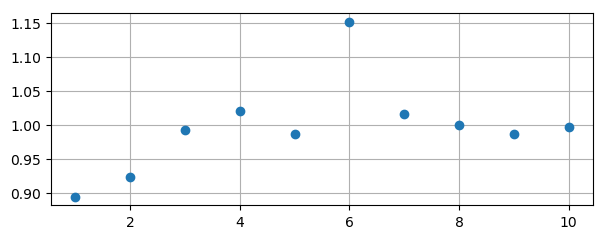

In [25]:
fig = figure("pyplot_barplot",figsize=(7,2.5))
plot(1:d, [compute_configT(my_model, xi_samples[:,1:end-1], hyper_samples[:,1:end-1], k) for k in 1:d], "o")
grid(true)

#### For GDP prior: 

* That doesn't look right. Something seems wrong with the sampler.